I've always been curious about the population growth of India (my home country). I wondered how easy or difficult it would be to model population growth using common time series analyses methods. This is an experiment to see how well different approaches work. 

In [131]:
import pandas as pd
import matplotlib
import statsmodels.api as sm
import numpy as np
import scipy 
import chardet

Getting Some population data from the world bank. We've removed some headers from the original spreadsheet, and saved it with utf encoding to avoid any encoding issues while reading. 

In [34]:
file = "../data/API_SP.POP.TOTL_DS2_en_csv_v2_3469297.csv"
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [35]:
df = pd.read_csv(file,encoding=result['encoding'])

In [36]:
df.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0,NaN
5,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,2866376.0,2854191.0,2837743.0,NaN
6,Andorra,AND,"Population, total",SP.POP.TOTL,13410.0,14378.0,15379.0,16407.0,17466.0,18542.0,...,82427.0,80770.0,79213.0,77993.0,77295.0,76997.0,77008.0,77146.0,77265.0,NaN
7,Arab World,ARB,"Population, total",SP.POP.TOTL,92197715.0,94724540.0,97334438.0,100034191.0,102832792.0,105736428.0,...,371437642.0,379696477.0,387899835.0,396028301.0,404042892.0,411942825.0,419851989.0,427870273.0,436080728.0,NaN
8,United Arab Emirates,ARE,"Population, total",SP.POP.TOTL,92417.0,100801.0,112112.0,125130.0,138049.0,149855.0,...,9141598.0,9197908.0,9214182.0,9262896.0,9360975.0,9487206.0,9630966.0,9770526.0,9890400.0,NaN
9,Argentina,ARG,"Population, total",SP.POP.TOTL,20481781.0,20817270.0,21153042.0,21488916.0,21824427.0,22159644.0,...,41733271.0,42202935.0,42669500.0,43131966.0,43590368.0,44044811.0,44494502.0,44938712.0,45376763.0,NaN


In [99]:
india = df[df['Country Name']=='India']
india

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
109,India,IND,"Population, total",SP.POP.TOTL,450547675.0,459642166.0,469077191.0,478825602.0,488848139.0,499123328.0,...,1.265780e+09,1.280842e+09,1.295601e+09,1.310152e+09,1.324517e+09,1.338677e+09,1.352642e+09,1.366418e+09,1.380004e+09,NaN


In [117]:
it = india.transpose()
it = it.drop(['Country Name','Country Code','Indicator Name','Indicator Code'])
it = it.reset_index()

In [128]:
it = it.rename(columns={'index':'year',it.columns[1]:'population'})
it = it.dropna()

<AxesSubplot:xlabel='year'>

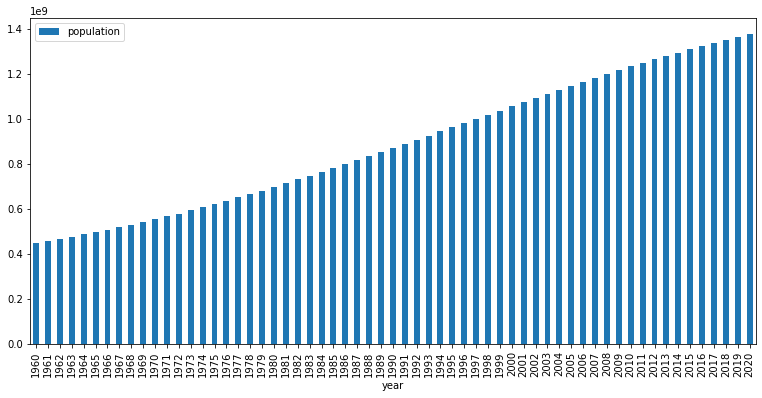

In [129]:
it.plot(kind='bar',x='year',y='population',figsize=(13,6))

It's clear from looking at this annual population data that there's no seasonality, but there's an obvious trend. We can probably use a very simple auto regression process to predict this. 

We can look at an auto regressive model as a baseline, and if there's any evidence that this is a moving average process, then we can try an ARMA process as well. 

AD Fuller Test for Stationarity: 

1. In this test the null hypothesis is that the series is not stationary and there is a unit root that causes the variance to not be constant over time 
1. The alternative hypothesis is that the series is stationary 

If the p-value is small then we can reject the null hypothesis and conclude that the series is stationary 

In [140]:
result = sm.OLS(y, x).fit()